## Network Aggregation Diagnosis

by: arezoo besharati, July 2018

In [1]:
import os; os.chdir('../')


import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook

import warnings;warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import warnings;warnings.simplefilter('ignore')

import pandana as pdna
import orca 
import seaborn as sns

%matplotlib inline

from scripts import datasources
from scripts import models


In [2]:
#! pip install mplleaflet
import mplleaflet as mpll

In [3]:

d = 'data/'
nodesdrive = pd.read_csv(d + 'bay_area_drive_full_nodes.csv').set_index('osmid')   
# nodesdrive is the raw csv for nodes from Geof
print(nodesdrive.shape)

nodesdrive.head()

(228066, 4)


x          y  ref            highway
osmid                                                  
25457926 -121.555923  36.999098  356  motorway_junction
25457938 -121.553913  37.007868  NaN    traffic_signals
25457946 -121.558396  37.007551  NaN                NaN
26392420 -121.384907  36.988574  NaN                NaN
26404828 -121.552105  37.006208  NaN    traffic_signals

In [4]:
%%capture
orca.run(["initialize_network_drive", 
          "network_aggregations_drive"])

In [5]:
# nodesdrive after network aggregation
nodesdrive_after = orca.get_table('nodesdrive').to_frame()

nodesdrive_after.shape

In [7]:
nodesdrive_after.columns.tolist()

['residential_units_500',
 'residential_units_1500',
 'population_1500',
 'poor_1500',
 'renters_1500',
 'med_income_1500',
 'job_1500',
 'ave_hhsize',
 'med_rent_1500']

In [8]:
#assign coardinates to nodesdrive_after from nodesdrive

nodesdrive_after= nodesdrive_after.merge(nodesdrive, how='outer', left_index=True, right_index=True)


### Explore job_1500

count    228066.000000
mean        747.387146
std        2662.565918
min           0.000000
25%          36.378699
50%         200.210922
75%         667.124344
max      108142.242188
Name: job_1500, dtype: float64


<IPython.core.display.Javascript object>


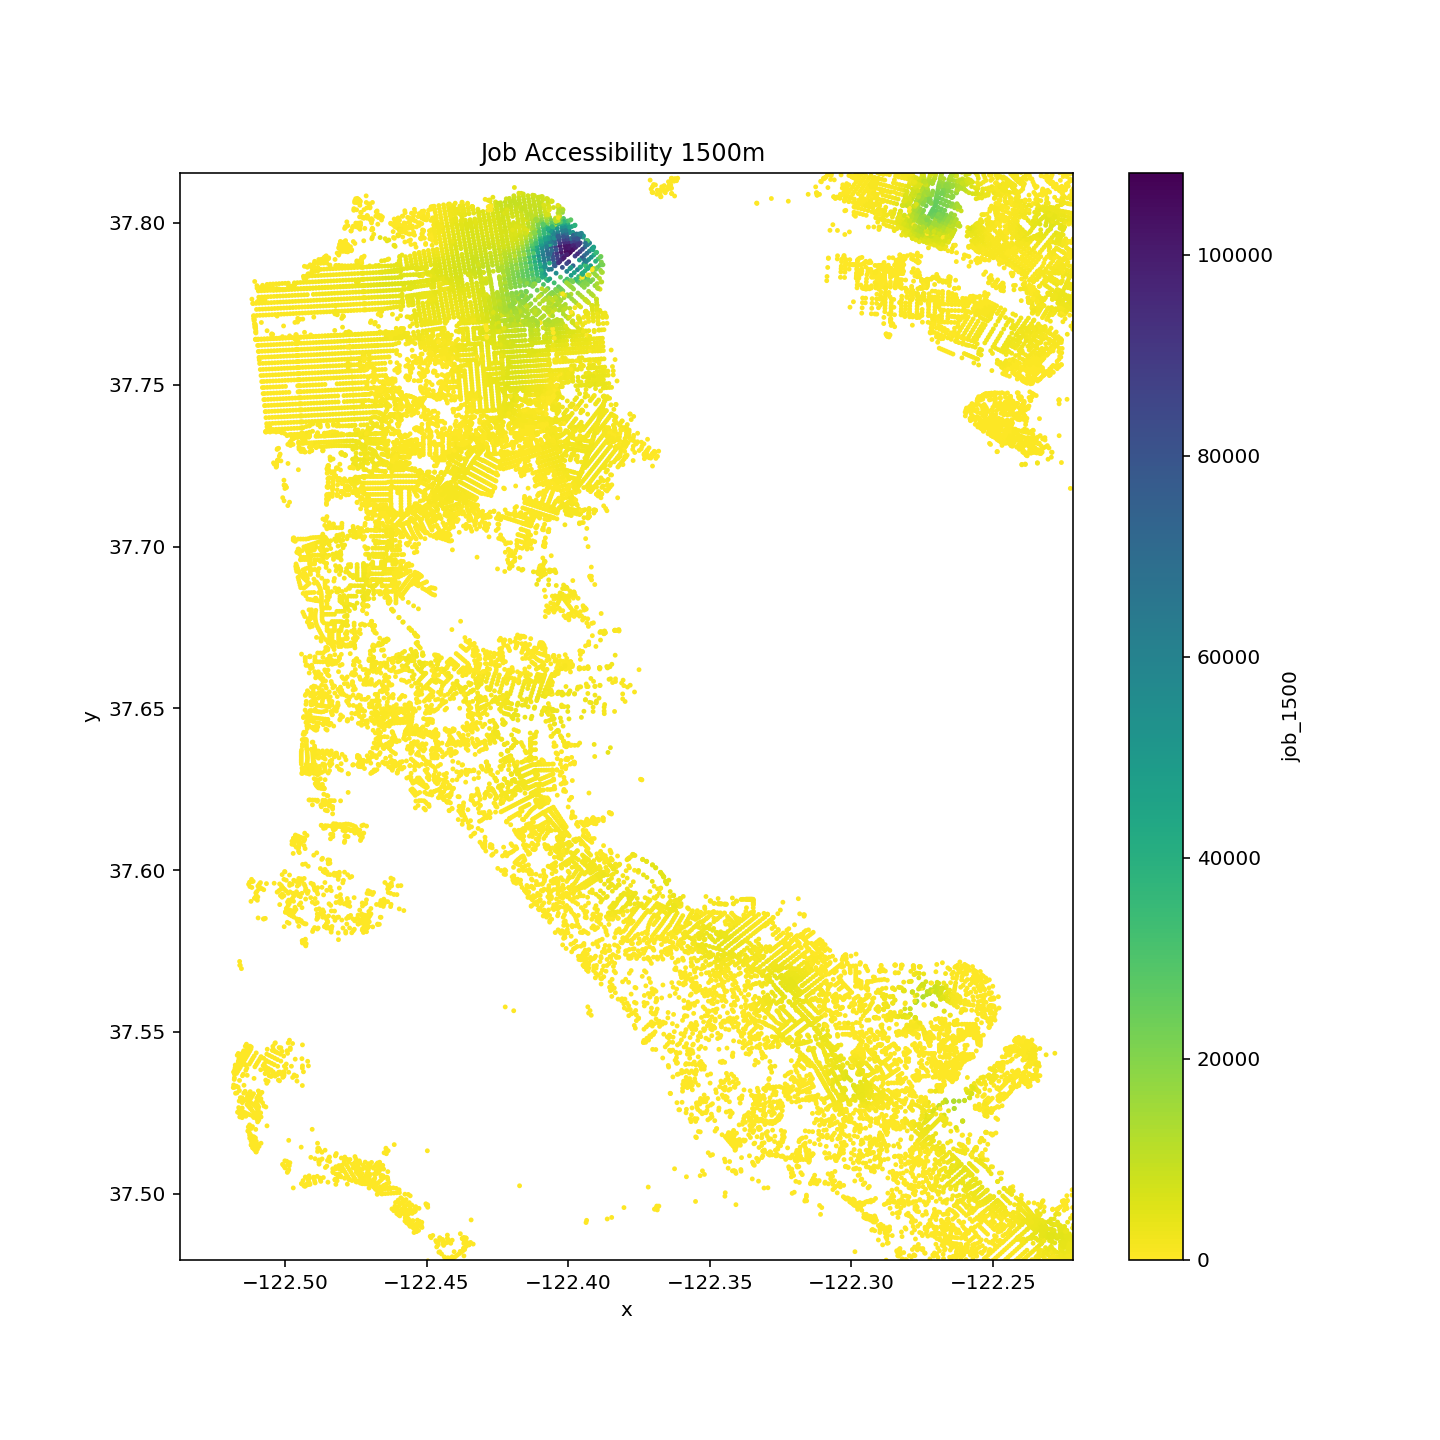

In [39]:
# plot the job_1500

print(nodesdrive_after.job_1500.describe())


f, ax = plt.subplots(1, figsize=(10, 10))
plt.title("Job Accessibility 1500m ")

nodesdrive_after.plot(kind='scatter', x='x', y='y', c='job_1500',cmap='viridis_r', s=2, 
          linewidth=1, ax=ax, legend=True)
plt.show()

### Explore med_income_1500

In [10]:
med_income_1500 = nodesdrive_after.med_income_1500

med_income_1500.describe()

count    228066.000000
mean      85057.148438
std       42531.875000
min          -1.000000
25%       65000.000000
50%       84800.000000
75%      107580.000000
max      776000.000000
Name: med_income_1500, dtype: float64

<IPython.core.display.Javascript object>


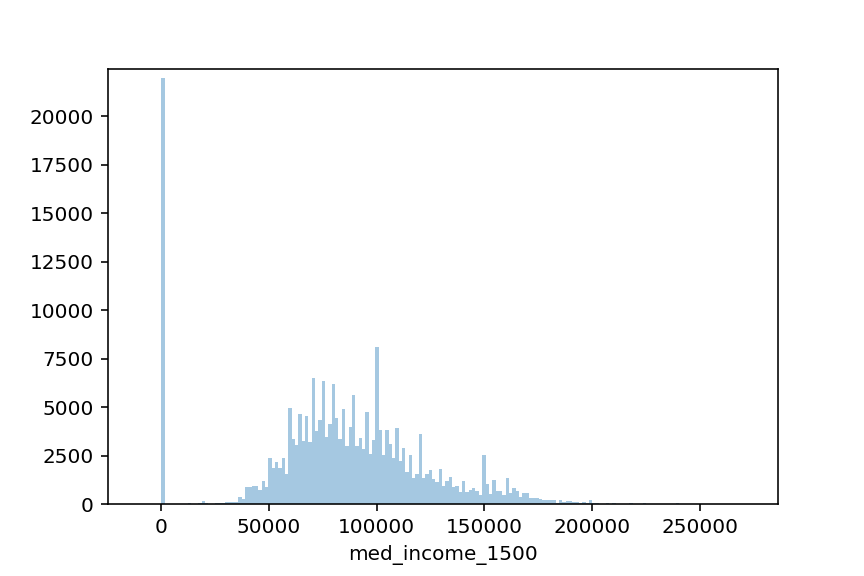

In [13]:
%matplotlib notebook

sns.distplot(nodesdrive_after.med_income_1500, bins=500, kde=False);


In [11]:
len(nodesdrive_after[nodesdrive_after.med_income_1500 < 0])

21977

<IPython.core.display.Javascript object>


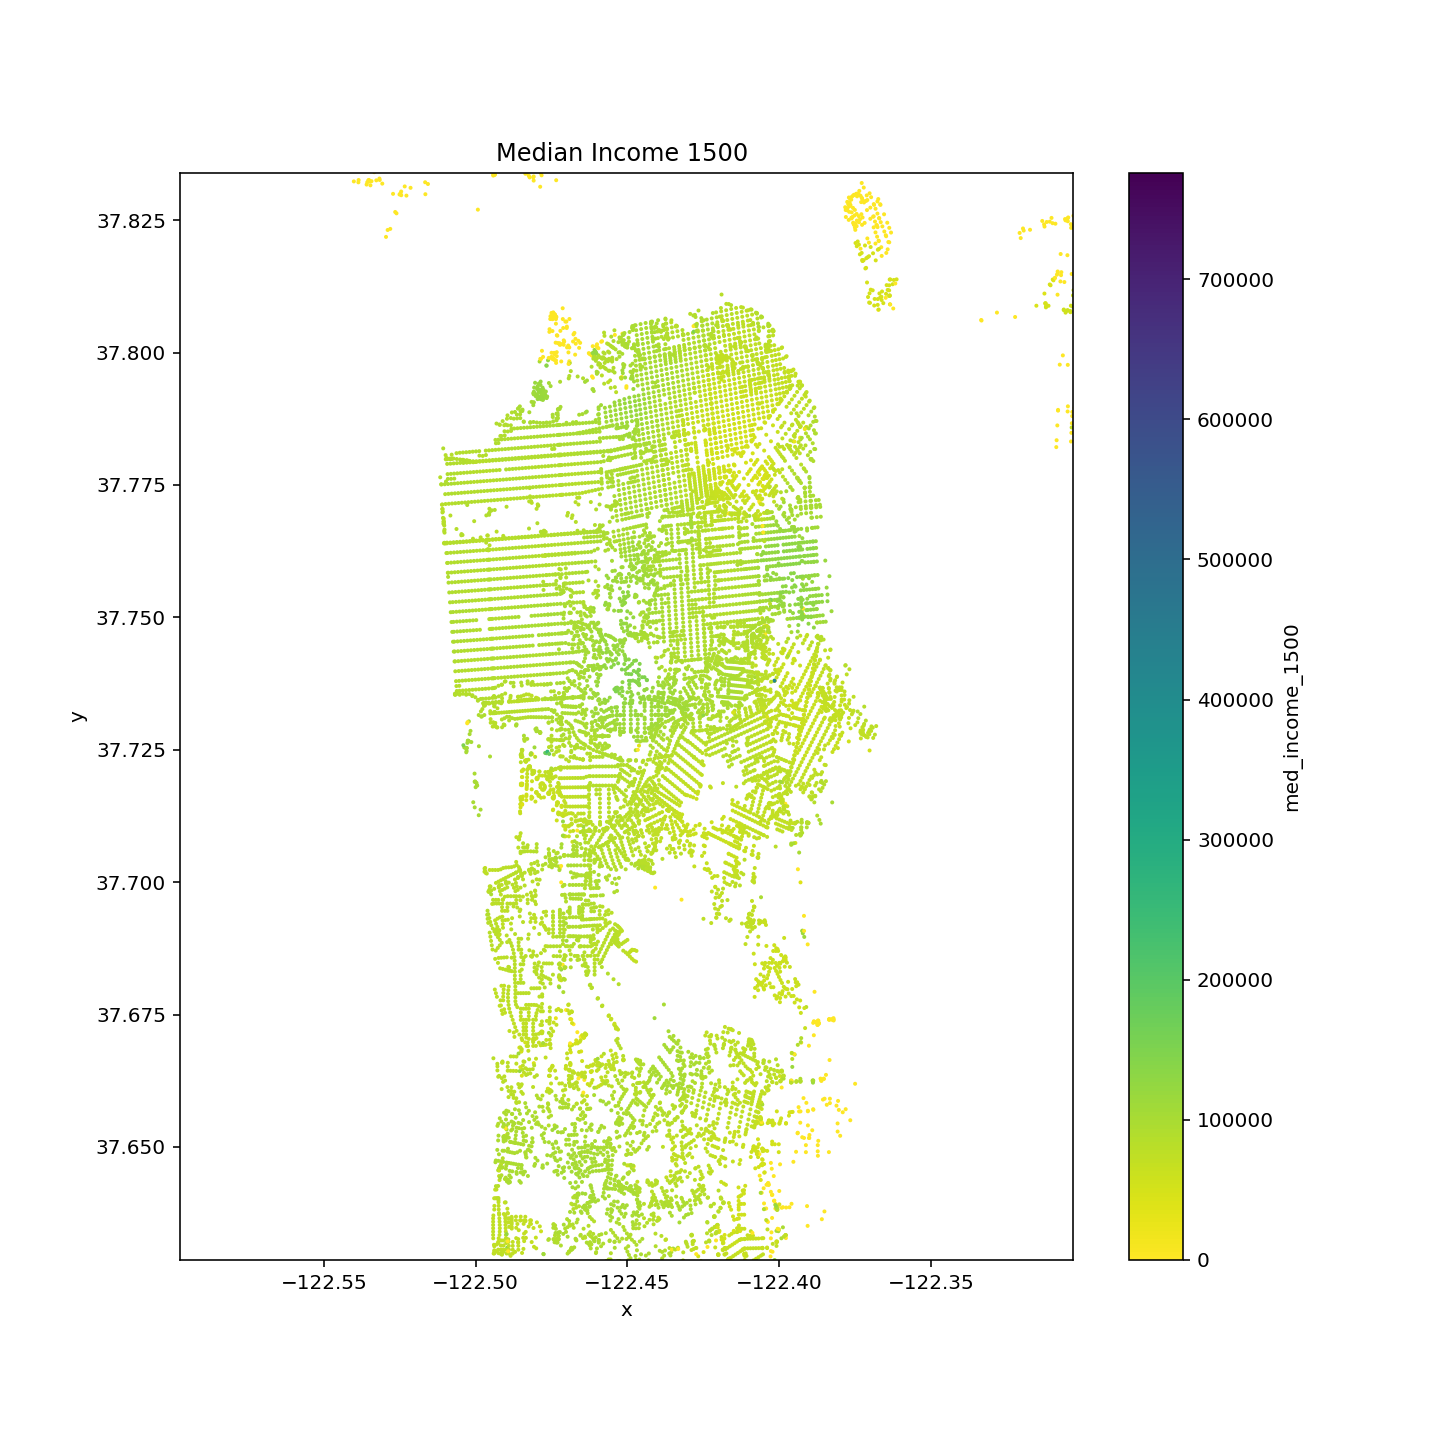

In [38]:
# plot the med_income_1500

f, ax = plt.subplots(1, figsize=(10, 10))
plt.title("Median Income 1500 ")

nodesdrive_after.plot(kind='scatter', x='x', y='y', c='med_income_1500',
                      cmap='viridis_r', s=1, 
                      linewidth=1, ax=ax, legend=True)
plt.show()

### Explore population_1500

In [15]:
nodesdrive_after.population_1500.describe()

count    228066.000000
mean       2056.405273
std        2537.344727
min           0.000000
25%         419.055779
50%        1456.121765
75%        2773.687805
max       39817.984375
Name: population_1500, dtype: float64

<IPython.core.display.Javascript object>


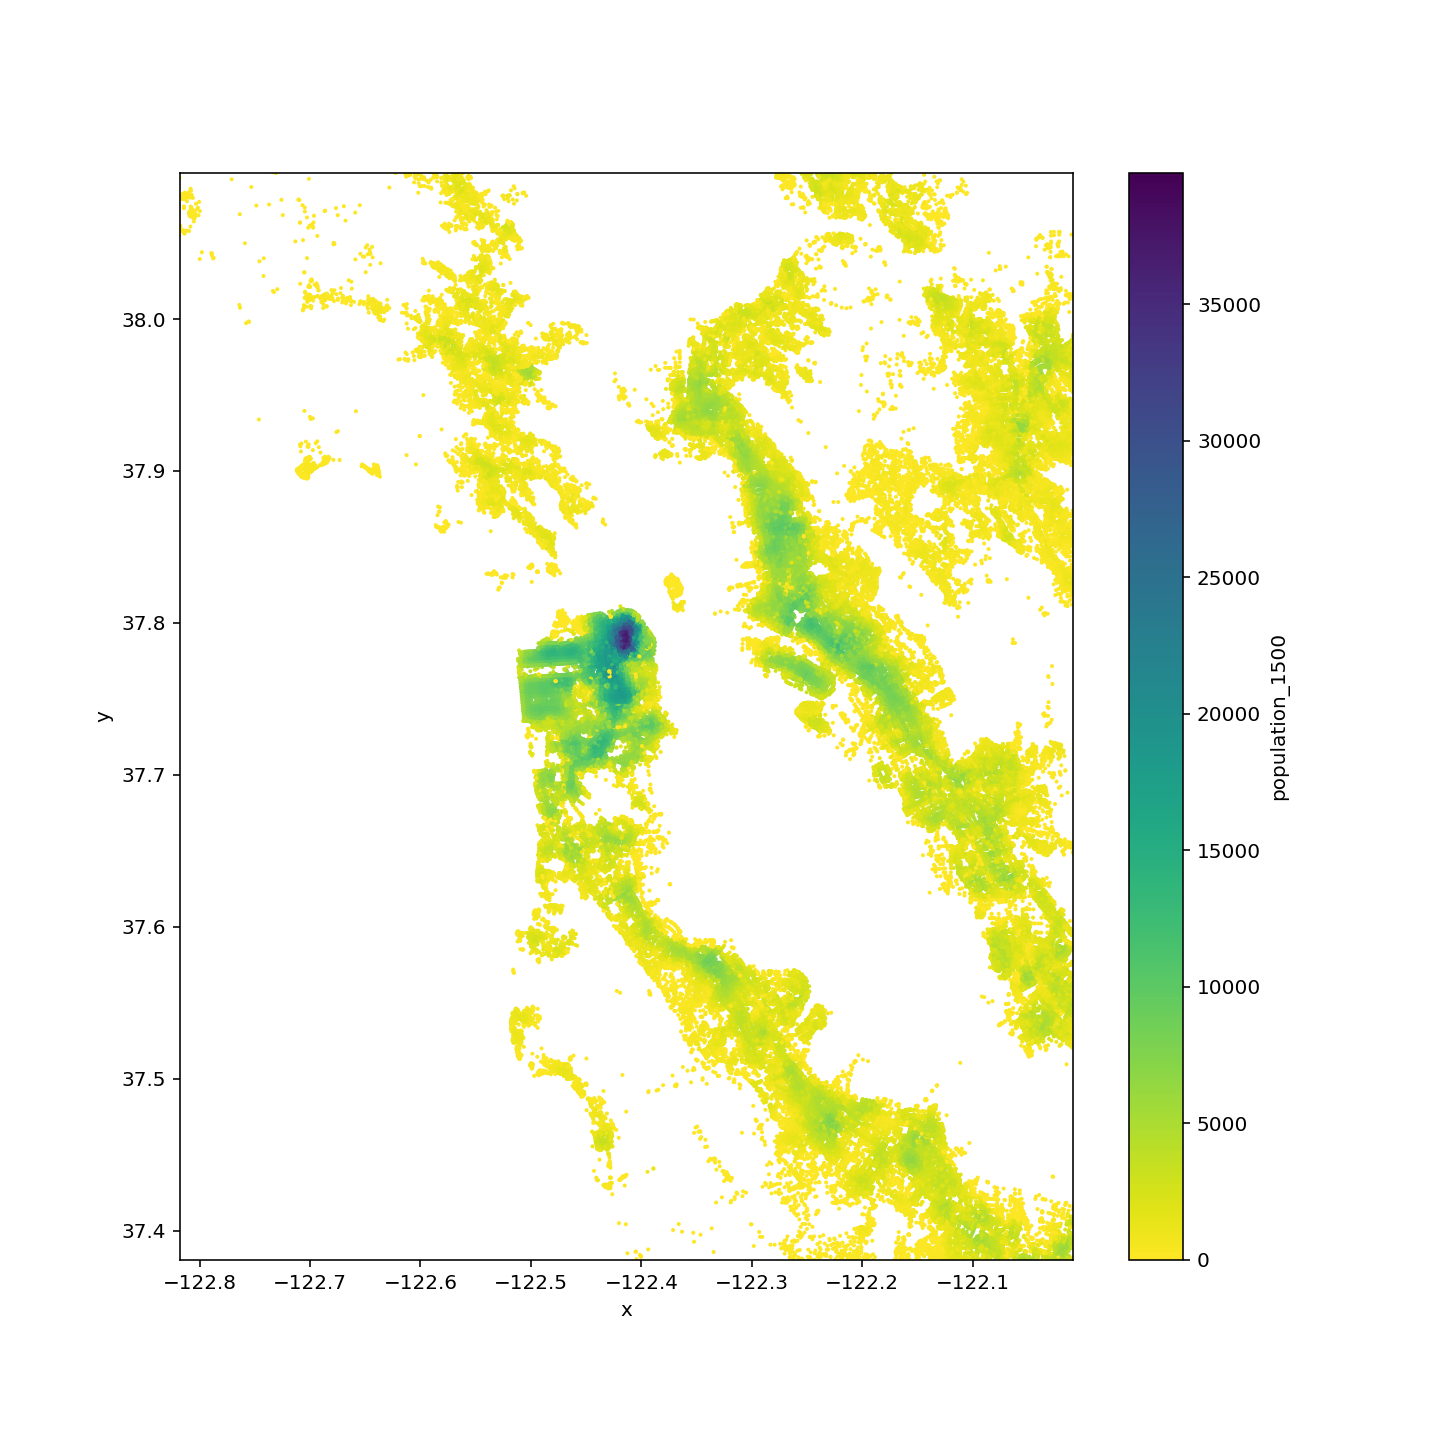

In [16]:
# PLOT the population_1500

f, ax = plt.subplots(1, figsize=(10, 10))
nodesdrive_after.plot(kind='scatter', x='x', y='y', c='population_1500',
                      cmap='viridis_r', s=1, 
                      linewidth=1, ax=ax, legend=True);
plt.show()


### Compare the income distribution of households and med_income by node from household table

In [17]:
hh= orca.get_table('households').to_frame()

<IPython.core.display.Javascript object>


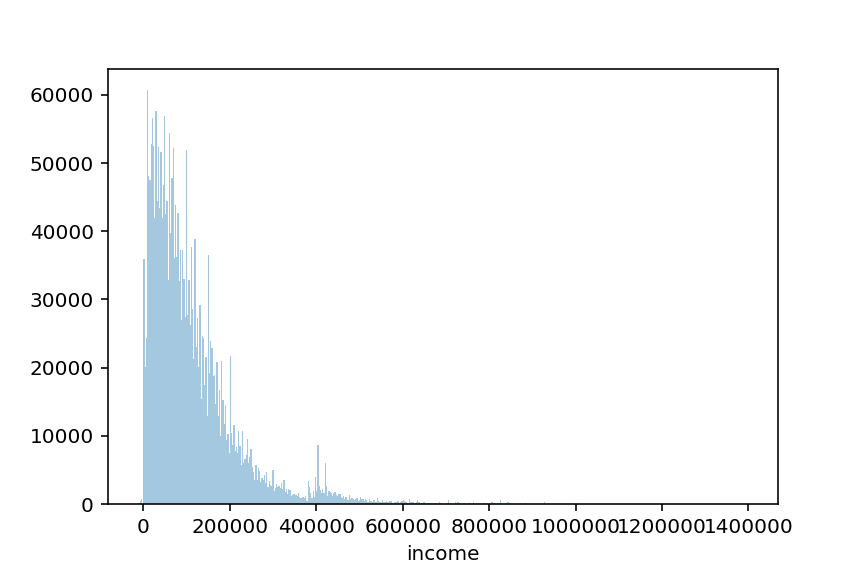

In [18]:
%matplotlib notebook

ax = sns.distplot(hh.income, bins=500, kde=False)

<IPython.core.display.Javascript object>


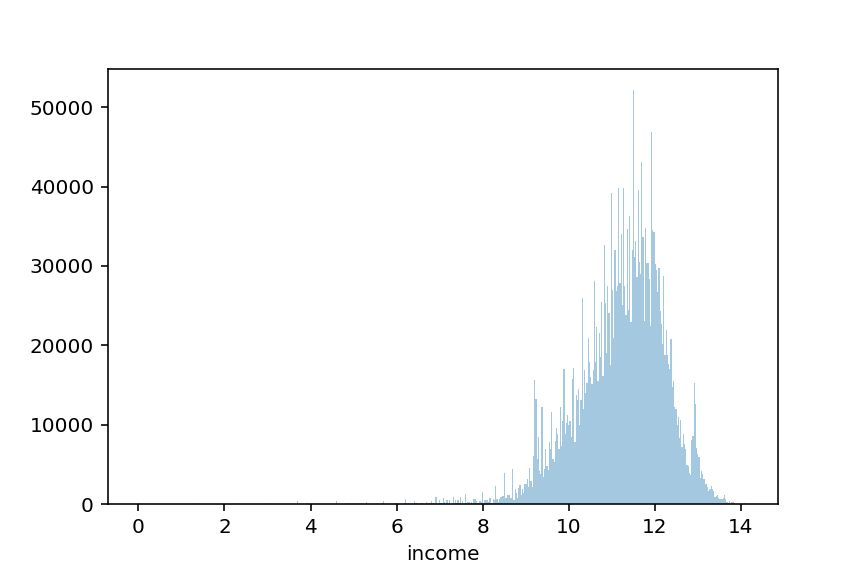

In [19]:
# Check the distribution after log transformation
%matplotlib notebook

filtered = hh[hh.income>0]
ax = sns.distplot(np.log(filtered.income), bins=500, kde=False)

In [20]:
med_income_by_node = hh.groupby('node_id_drive')[['income']].median().reset_index()

<IPython.core.display.Javascript object>


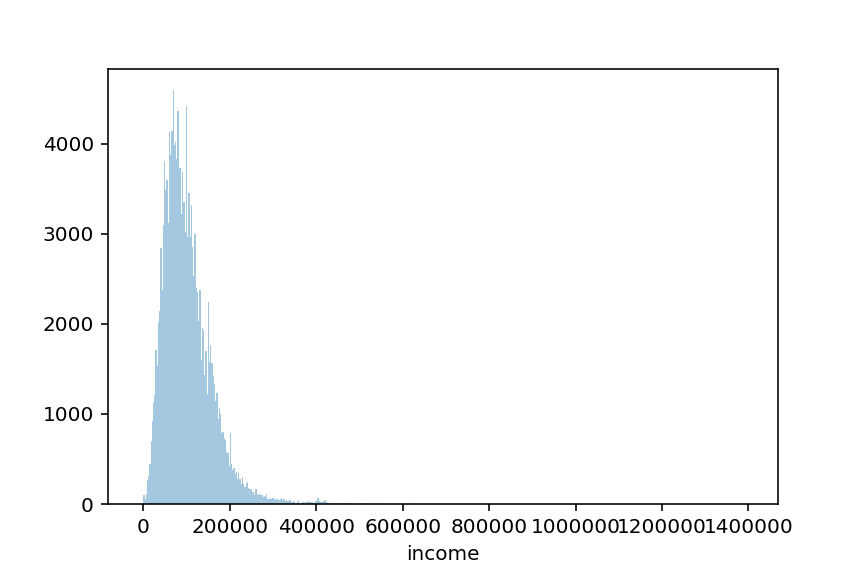

In [21]:
%matplotlib notebook

ax = sns.distplot(med_income_by_node.income, bins=500, kde=False)

<IPython.core.display.Javascript object>


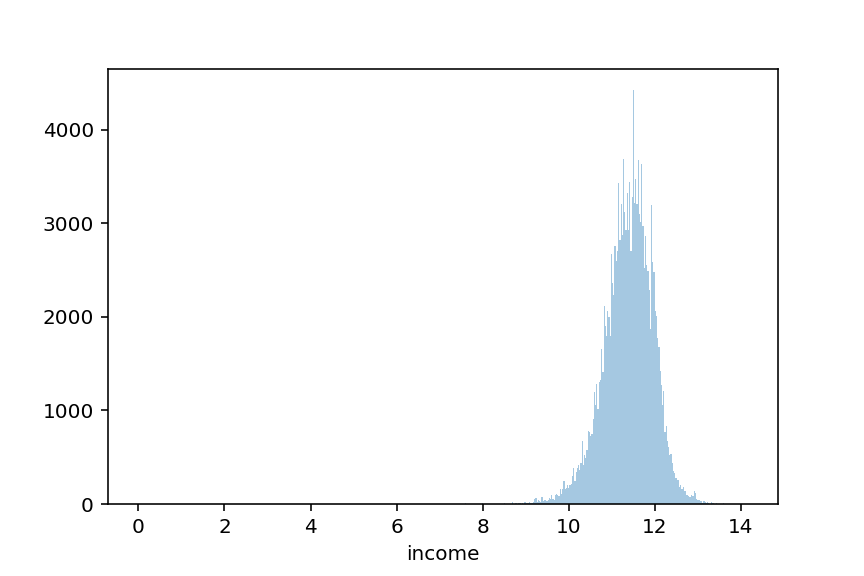

In [22]:
%matplotlib notebook

filtered = med_income_by_node[med_income_by_node.income>0]

ax = sns.distplot(np.log(filtered.income), bins=500, kde=False)

In [24]:
med_income_by_node['osmid'] = med_income_by_node['node_id_drive']
df = med_income_by_node.set_index('osmid')
data = df['income']

In [25]:
nodesdrive = nodesdrive.reset_index()
print (nodesdrive.shape)
print (med_income_by_node.shape)

(228066, 5)
(161961, 3)


In [26]:
med_income_by_node.osmid = med_income_by_node.osmid.astype(int)
med_income_by_node_2 = med_income_by_node.merge(nodesdrive, on='osmid', how = 'right')
print(med_income_by_node_2.shape)
med_income_by_node_2 = med_income_by_node_2.fillna(0)

(228066, 7)


<IPython.core.display.Javascript object>


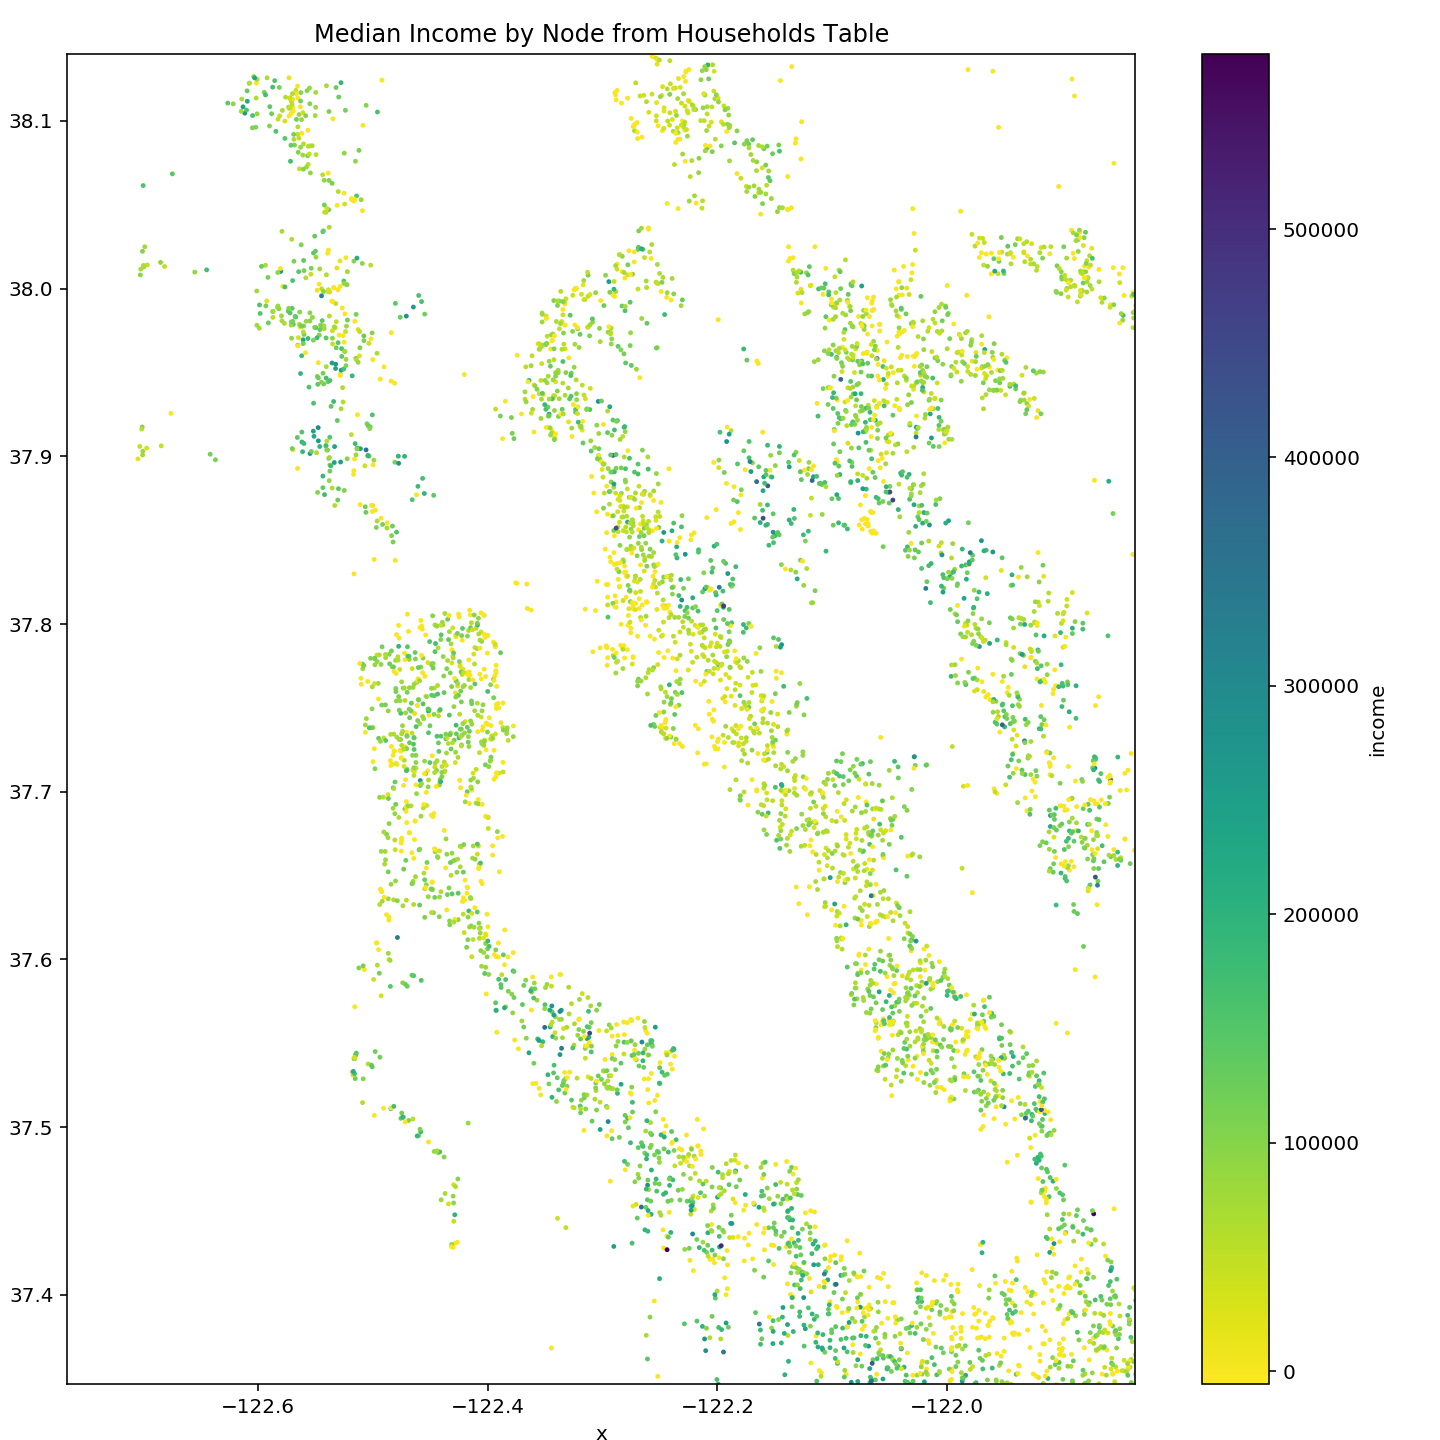

In [37]:

data = med_income_by_node_2.sample(10000)

f, ax = plt.subplots(1, figsize=(10, 10))
plt.title("Median Income by Node from Households Table")
plt.tight_layout()
data.plot(kind='scatter', x='x', y='y', c='income',
                      cmap='viridis_r', s=2, 
                      linewidth=1, ax=ax, legend=True);
plt.show()

** This doesn't look right **

### Explore residential_units_500

<IPython.core.display.Javascript object>


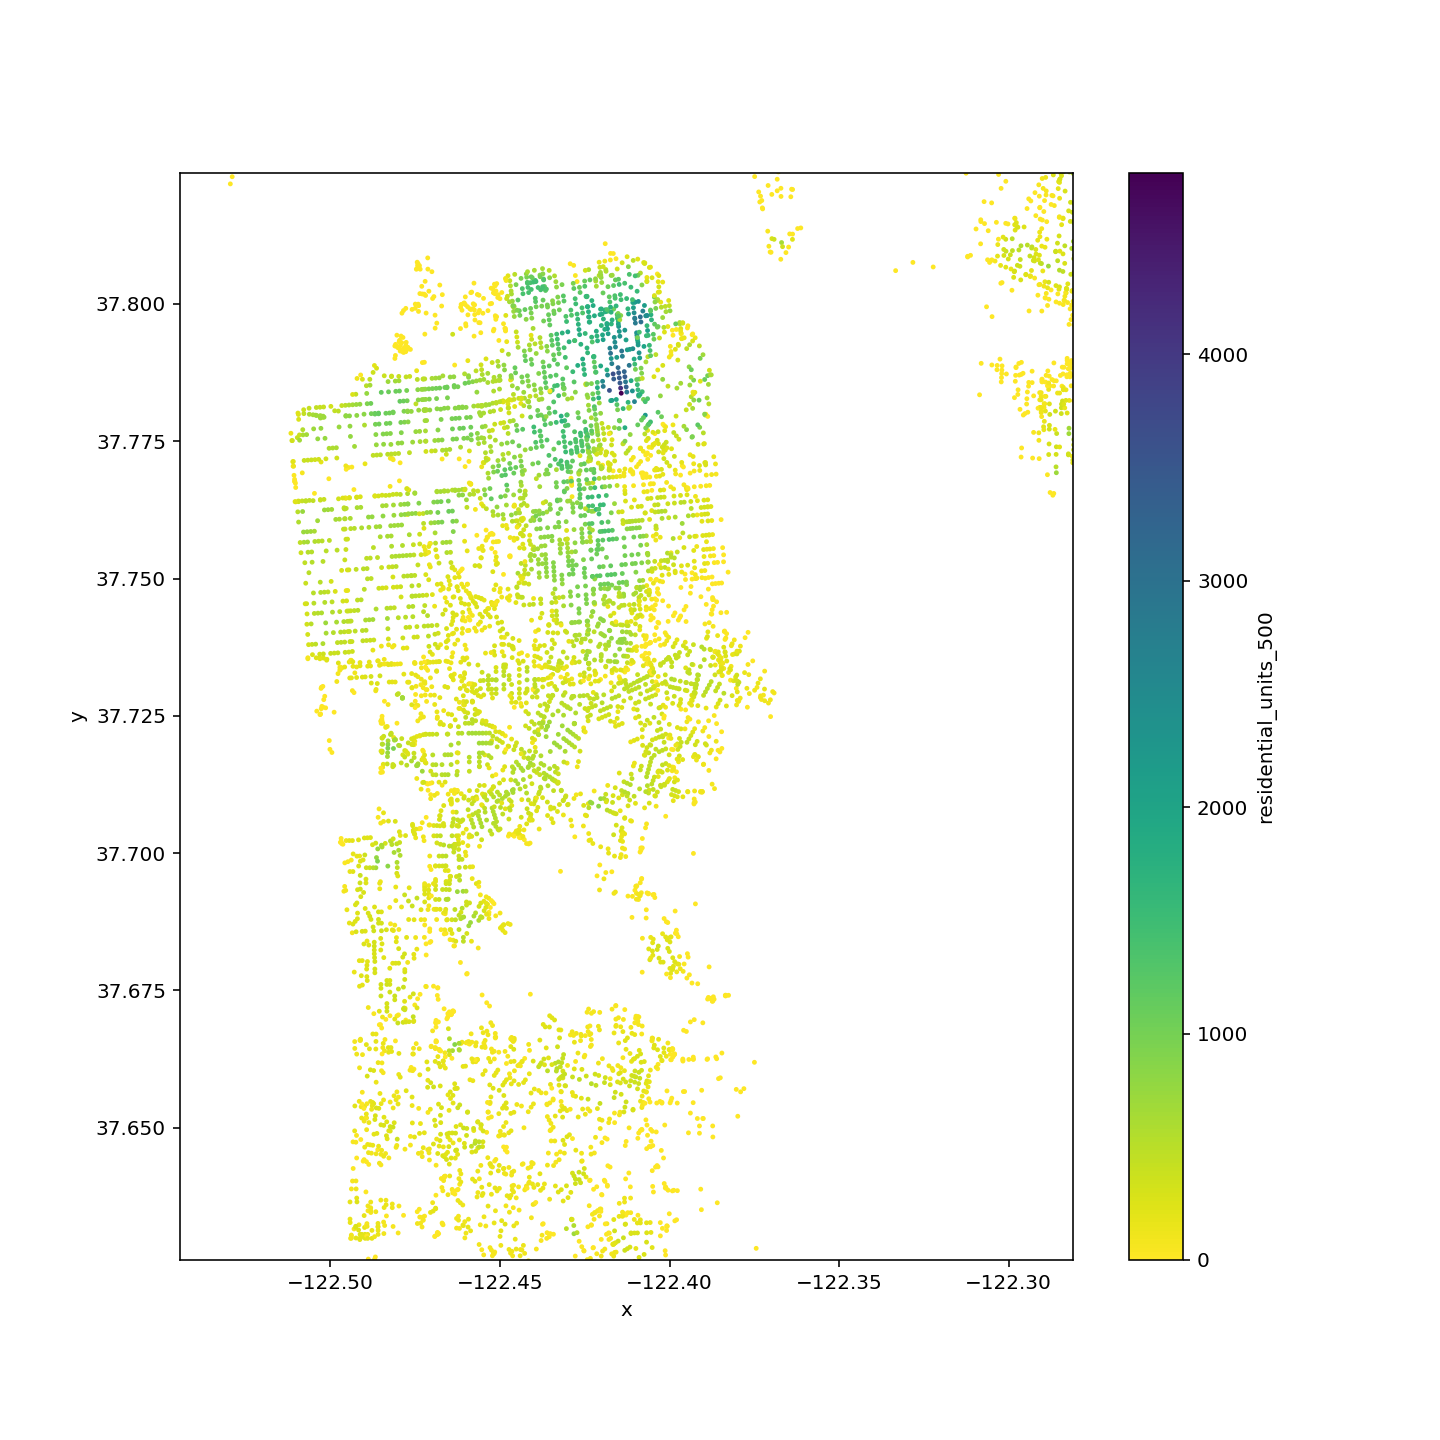

In [30]:
data = nodesdrive_after.sample(100000)
f, ax = plt.subplots(1, figsize=(10, 10))
data.plot(kind='scatter', x='x', y='y', c='residential_units_500',cmap='viridis_r', s=2, 
          linewidth=1, ax=ax, legend=True)


<IPython.core.display.Javascript object>


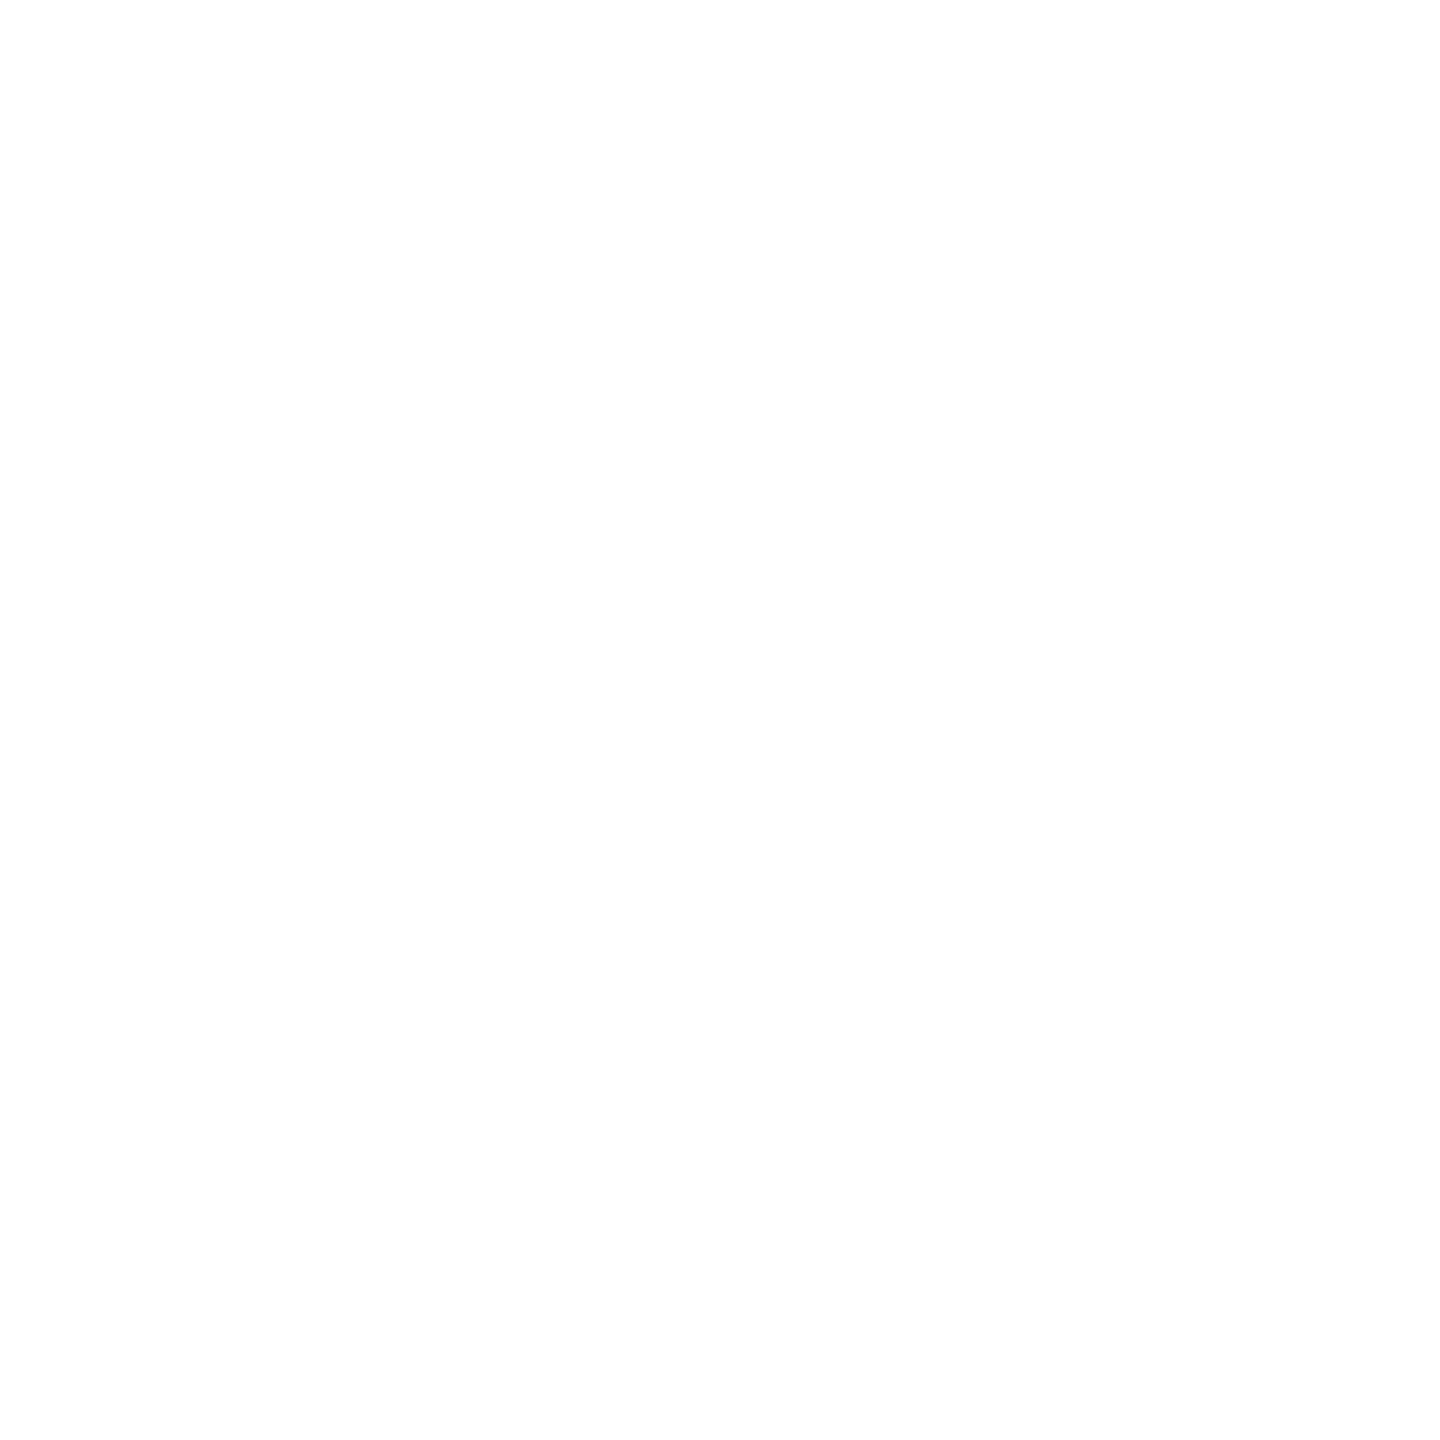

In [34]:
data = nodesdrive_after.sample(5000)
f, ax = plt.subplots(1, figsize=(10, 10))
data.plot(kind='scatter', x='x', y='y', c='residential_units_500',cmap='viridis_r', s=5,
          linewidth=1, ax=ax, legend=True)
mpll.show(fig=f,tiles='cartodb_positron', path='residential_units_500.html')